### Import libraries

In [47]:
import os
import sys

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings

warnings.filterwarnings("ignore")

import importlib

### Preprocessing / QC

#### Read data

In [48]:
data_path = "../data/S3"
data = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

#### Aggregate probes through maxpooling

In [49]:
data_maxpool = up.prep_probe_BacSC_data(data, agg_fn=np.max)
sc.pp.calculate_qc_metrics(
    data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True
)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [50]:
print(
    f"Zero inflation of probe-wise data: {((np.prod(data.X.shape) - data.X.getnnz()) / np.prod(data.X.shape)).round(3)}"
)
print(
    f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}"
)

Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


#### Filter cells

In [51]:
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    1544
True      108
Name: outlier, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

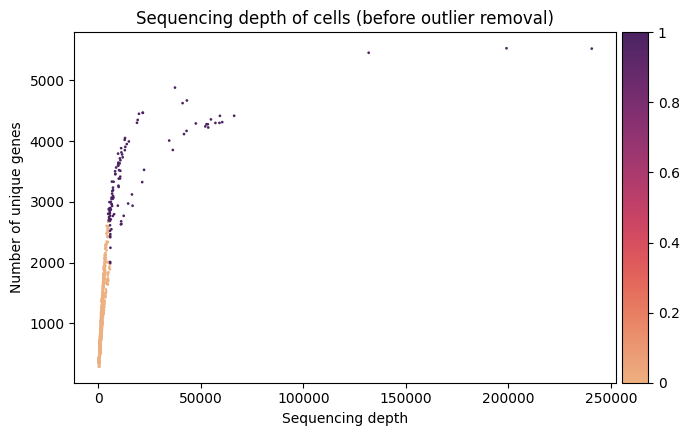

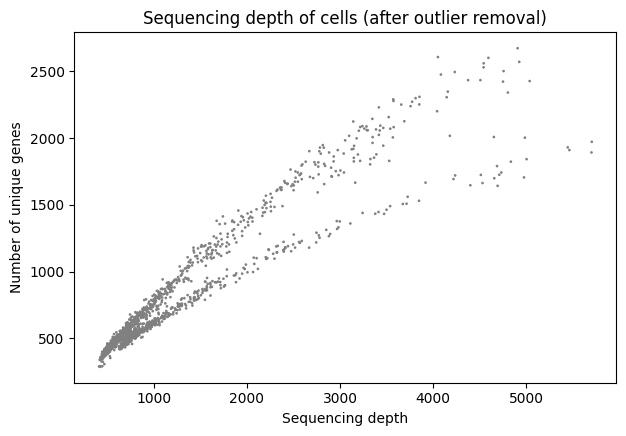

In [52]:
g = sc.pl.scatter(
    data_maxpool,
    x="total_counts",
    y="n_genes_by_counts",
    color="outlier",
    show=False,
    size=15,
    color_map="flare",
    title="Sequencing depth of cells (before outlier removal)",
)
g.set(xlabel="Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x="total_counts", y="n_genes_by_counts", show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

#### Variance stabilization

In [53]:
data_gene.layers["counts"] = data_gene.X.copy()

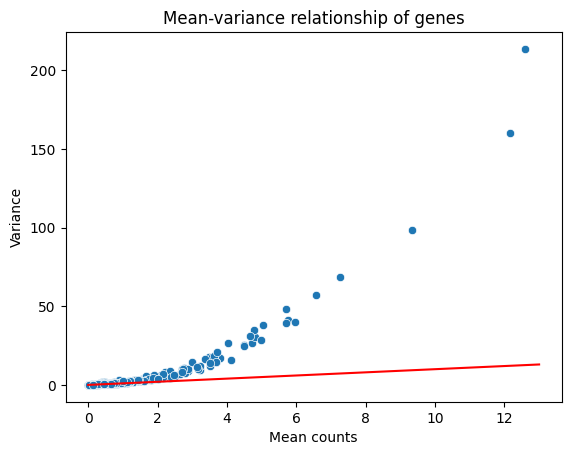

In [54]:
data_gene.var["var_counts"] = np.asarray(
    np.var(data_gene.X.toarray(), axis=0)
).squeeze()
data_gene.var["mean_counts"] = np.asarray(
    np.mean(data_gene.X.toarray(), axis=0)
).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot(
    [0, np.ceil(np.max(data_gene.var["mean_counts"]))],
    [0, np.ceil(np.max(data_gene.var["mean_counts"]))],
    color="red",
)
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [55]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[
    0, 1
]
mv_corr_sq = np.corrcoef(
    data_gene.var["mean_counts"] ** 2, data_gene.var["var_counts"]
)[0, 1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
    print("Data is overdispersed.")
else:
    is_overdispersed = False
    print("Data is not overdispersed.")

Data is overdispersed.


#### Estimate negative binomial parameters for each gene

In [56]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=77465000)

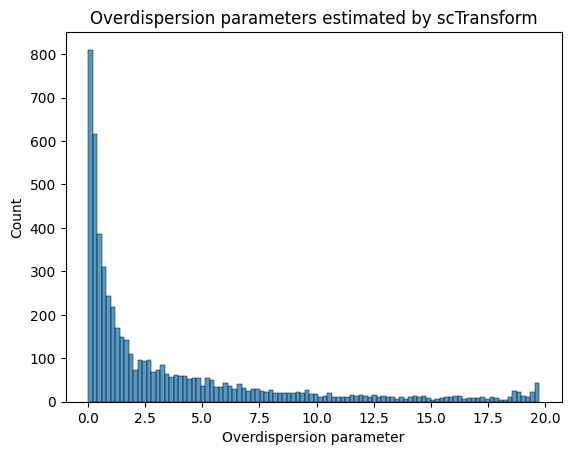

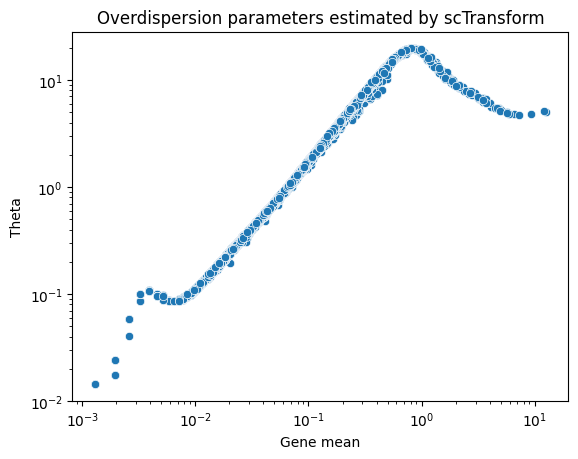

In [57]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [58]:
data_gene.X = data_gene.layers["counts"].copy()

#### Normalization, VST, scaling and PCA

In [59]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(
        np.log(
            data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)
        )
    )
else:
    data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.tl.pca(data_gene, svd_solver="arpack")

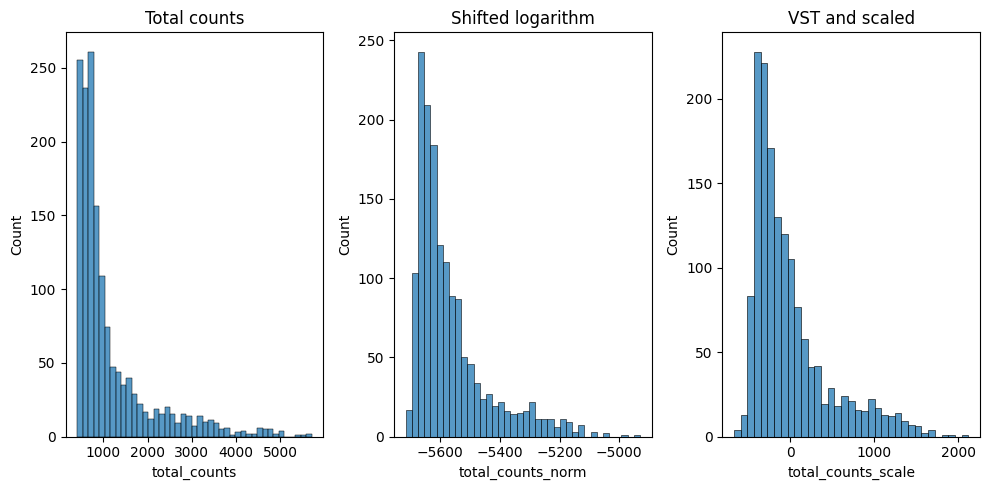

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(
    data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack"
)
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(
    data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack"
)
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(
    data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack"
)
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

### PCA

#### Count-split into training and test data

In [61]:
seed_countsplit = 9874516

In [62]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(
    data_gene,
    data_dist=data_dist,
    beta_key="nb_overdisp_cutoff",
    layer="counts",
    min_genes=1,
    max_counts=1e9,
    seed=seed_countsplit,
)
print(data_train)

AnnData object with n_obs × n_vars = 1544 × 5504
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


Transformation, centering and PCA

In [63]:
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(
        np.log(
            data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)
        )
    )
else:
    data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver="arpack")


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(
        np.log(
            data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)
        )
    )
else:
    data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver="arpack")

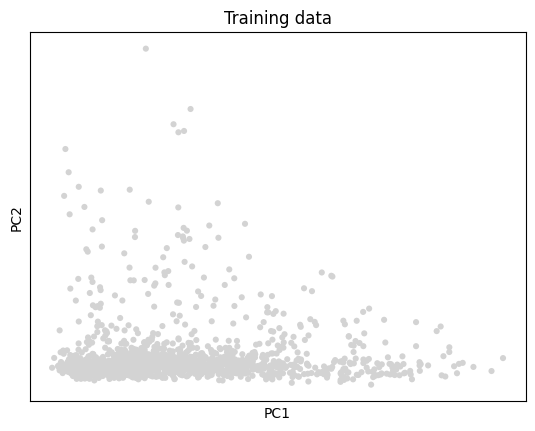

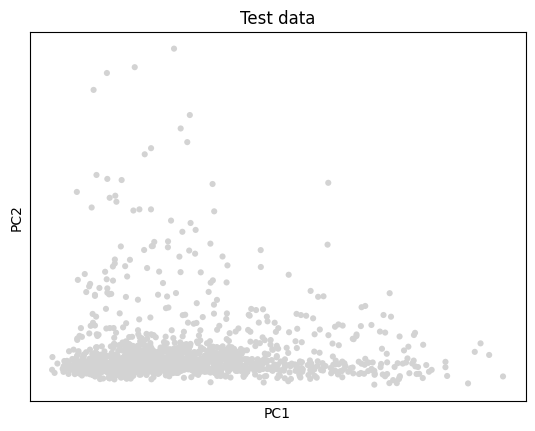

In [64]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

#### Select top-k Principal Components

In [65]:
importlib.reload(cs)

<module 'tools.countsplit' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/countsplit.py'>

In [66]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


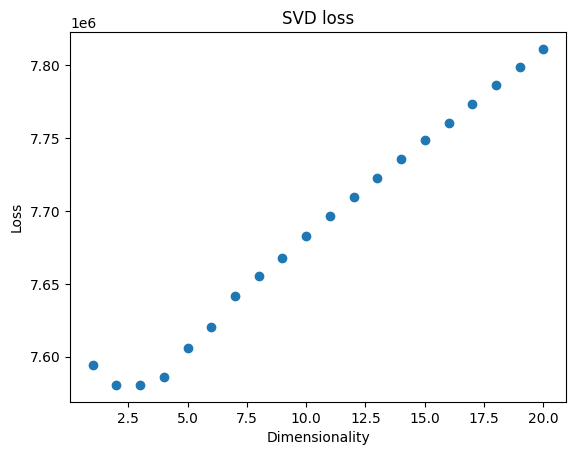

In [67]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

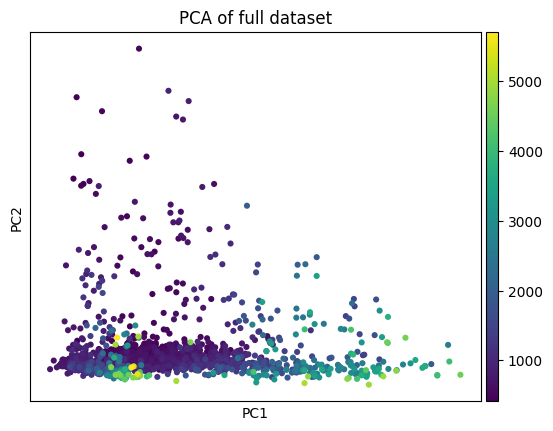

In [68]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [69]:
data_gene.uns["BacSC_params_PCA"] = {"k_opt": k_opt}

### UMAP

#### Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [70]:
seed_scdeed = 9874516

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

In [71]:
importlib.reload(scd)

<module 'tools.scDEED' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/scDEED.py'>

In [72]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'pca', 'BacSC_params_PCA'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [73]:
(
    scdeed_result,
    rel_scores,
    null_rel_scores,
    reliabilities,
    n_neighbors_opt,
    min_dist_opt,
) = scd.scdeed_parameter_selection(
    data_gene,
    n_neighborss,
    min_dists,
    n_pcs=k_opt,
    rng_seed=seed_scdeed,
    embedding_method="UMAP",
    similarity_percent=0.5,
    save_path="../data/S3/S3_filtered_scdeed_pca",
)

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

In [74]:
n_neighbors_opt = 40
min_dist_opt = 0.1

Optimal number of neighbors: 40
Optimal min_dist: 0.1


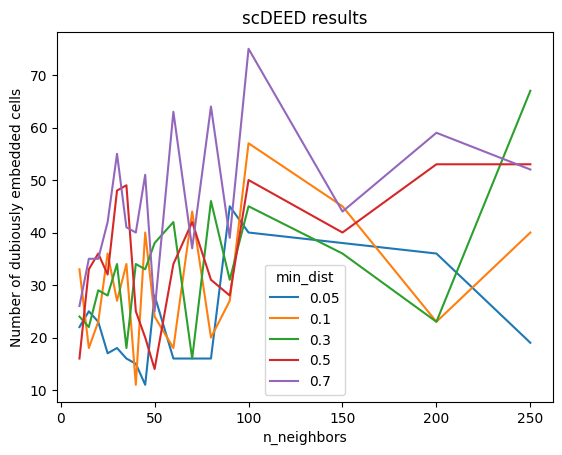

In [75]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(
    data=scdeed_result,
    x="n_neighbors",
    y="num_dubious",
    hue="min_dist",
    palette="tab10",
)
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [76]:
data_gene.uns["BacSC_params_PCA"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params_PCA"]["min_dist_opt"] = min_dist_opt

In [77]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'pca', 'BacSC_params_PCA'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [78]:
sc.pp.neighbors(
    data_gene,
    n_neighbors=n_neighbors_opt,
    n_pcs=k_opt,
    key_added="PCA",
    use_rep="X_pca",
)
sc.tl.umap(
    data_gene,
    neighbors_key="PCA",
    min_dist=min_dist_opt,
    spread=1,
    random_state=seed_scdeed,
)

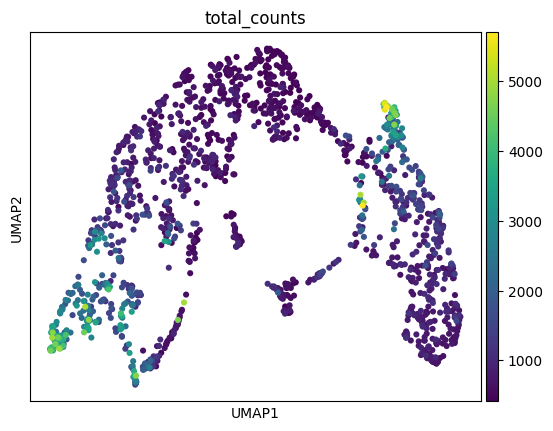

In [79]:
sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

### Clustering

#### Prepare train/test data

In [80]:
sc.pp.neighbors(
    data_train,
    n_neighbors=n_neighbors_opt,
    n_pcs=k_opt,
    key_added="PCA",
    use_rep="X_pca",
)
sc.tl.umap(
    data_train,
    neighbors_key="PCA",
    min_dist=min_dist_opt,
    spread=1,
    random_state=seed_scdeed,
)

sc.pp.neighbors(
    data_test,
    n_neighbors=n_neighbors_opt,
    n_pcs=k_opt,
    key_added="PCA",
    use_rep="X_pca",
)
sc.tl.umap(
    data_test,
    neighbors_key="PCA",
    min_dist=min_dist_opt,
    spread=1,
    random_state=seed_scdeed,
)

In [81]:
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(
    data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy()
)
data_test.obsm["X_umap_rot"] = umap_2_opt

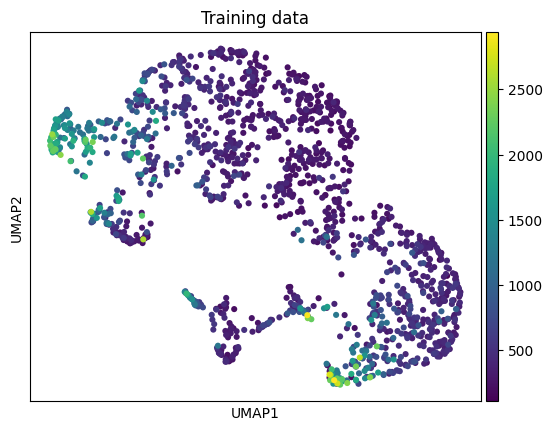

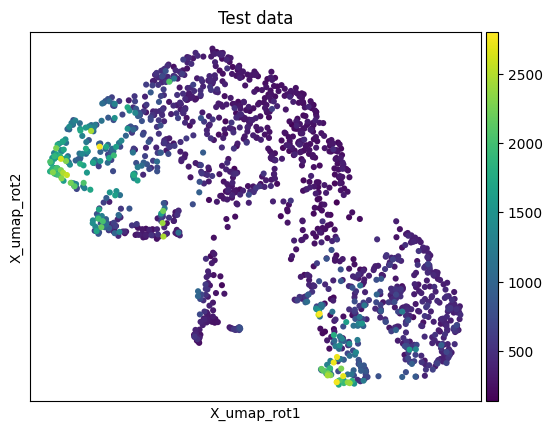

In [82]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(
    data_test,
    basis="X_umap_rot",
    color="total_counts",
    cmap="viridis",
    title="Test data",
)
plt.show()

#### Search clustering resolution

In [83]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)
print(f"Resolutions to test: {resolutions}")

Resolutions to test: [0.01 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49]


In [84]:
data_train

AnnData object with n_obs × n_vars = 1544 × 5504
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'pca', 'PCA', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'PCA_distances', 'PCA_connectivities'

In [85]:
importlib.reload(co)

<module 'tools.clustering_opt' from '/Users/stffn/projects/thesis_dev/msc_thesis/application/tools/clustering_opt.py'>

In [86]:
co.cluster_train_test(
    data_train,
    data_test,
    resolutions,
    alg="leiden",
    random_state=234,
    neighbors_key="PCA",
)

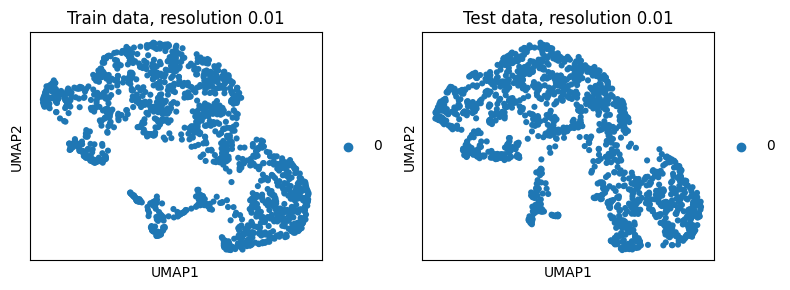

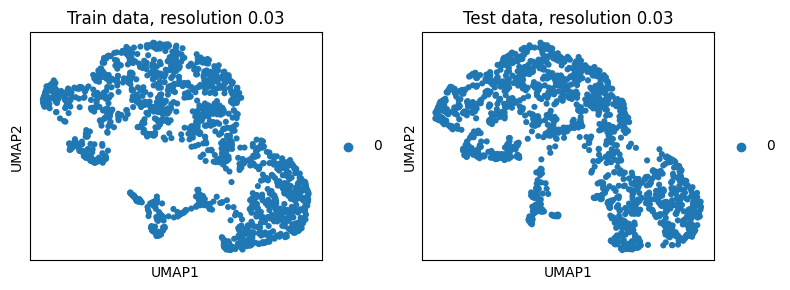

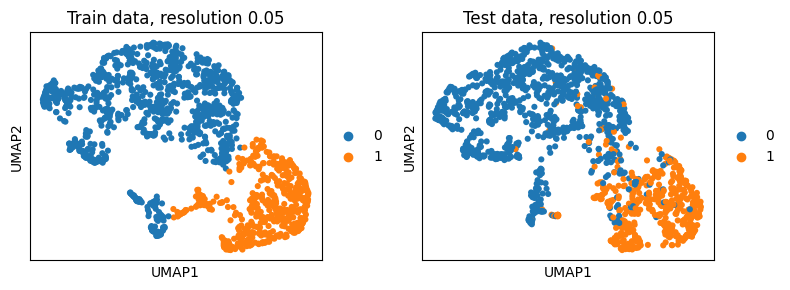

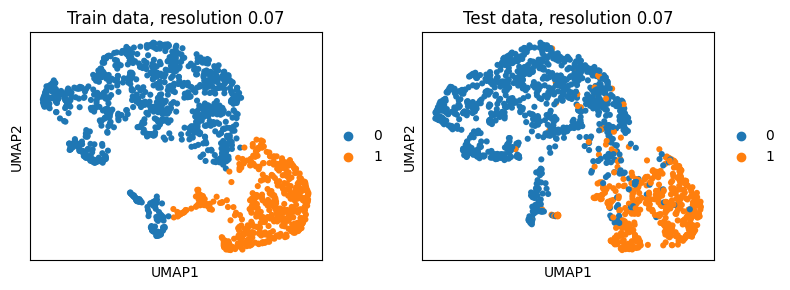

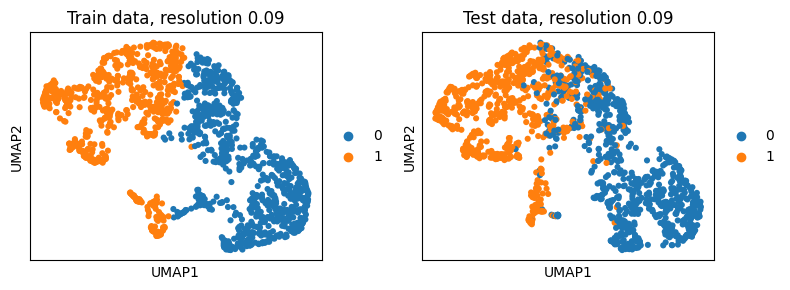

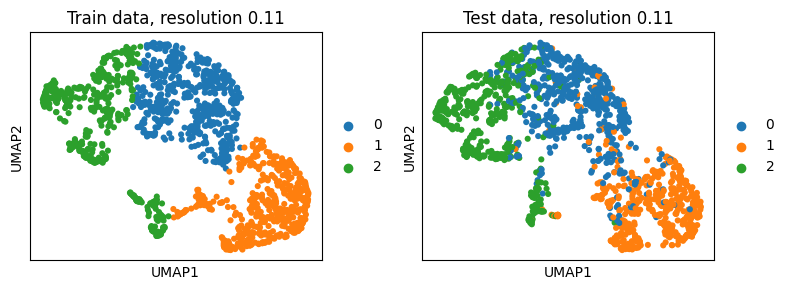

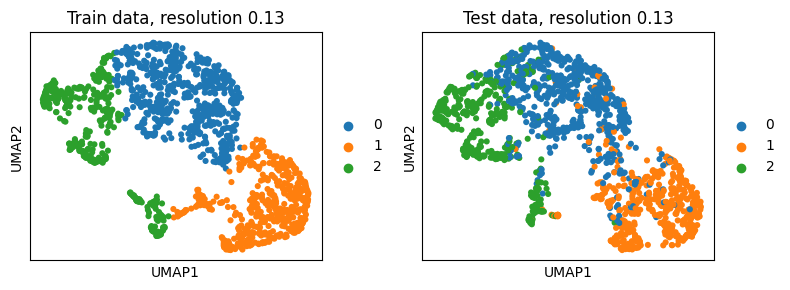

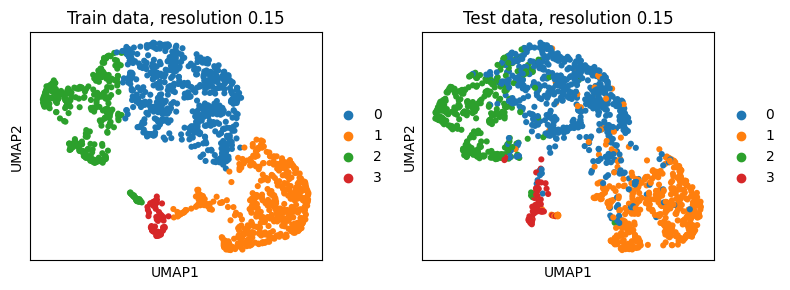

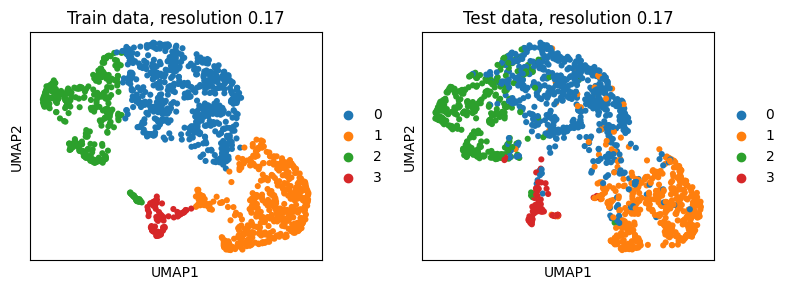

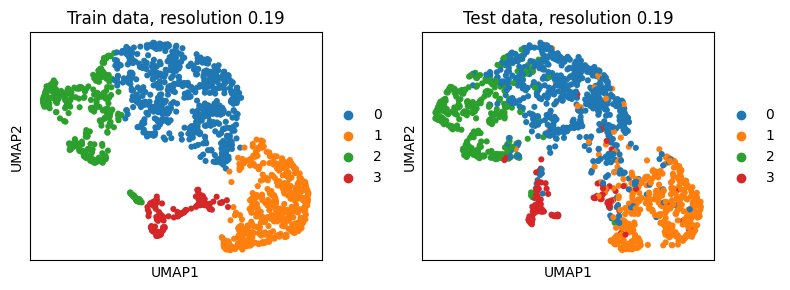

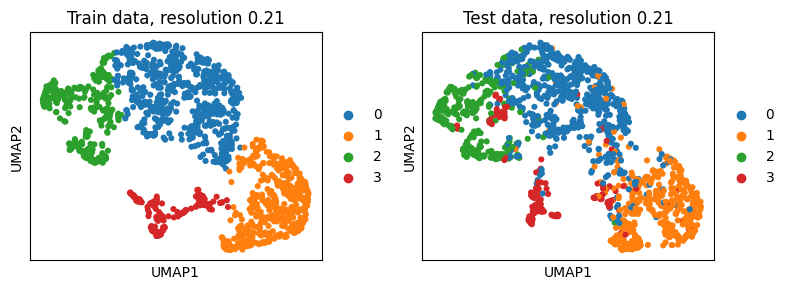

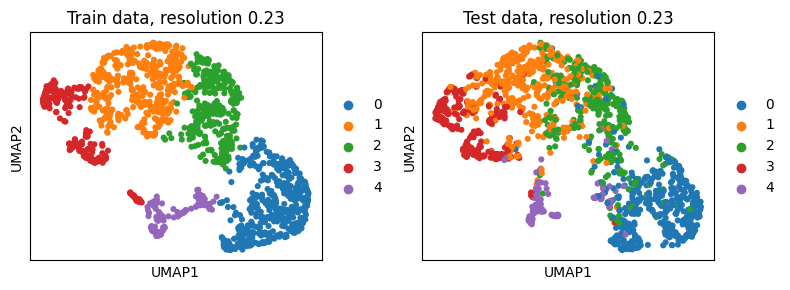

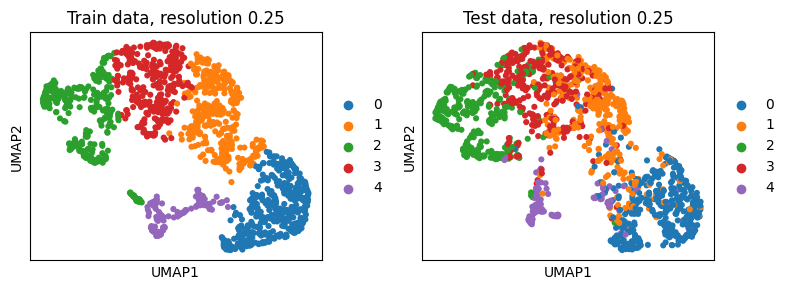

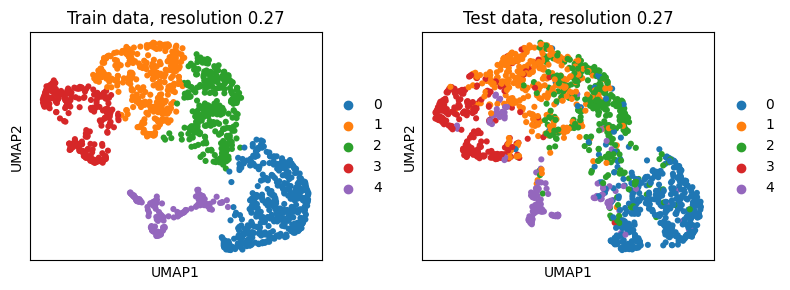

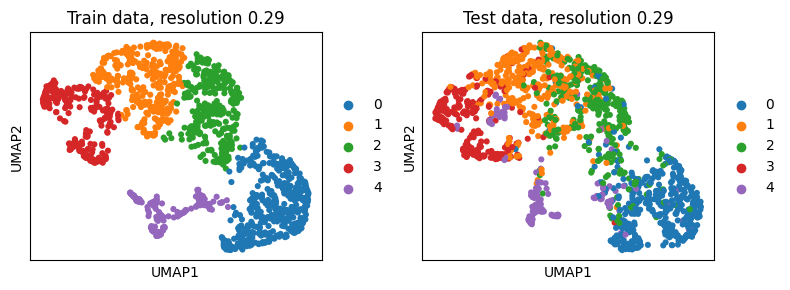

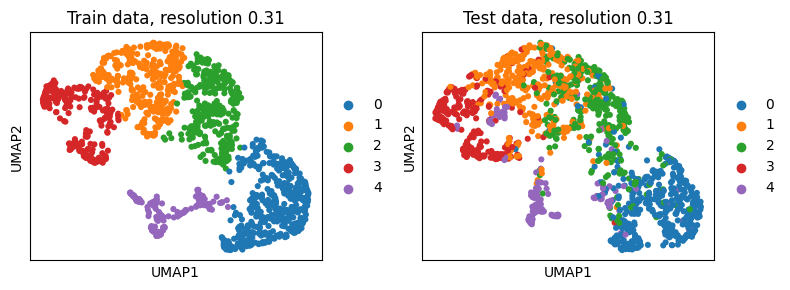

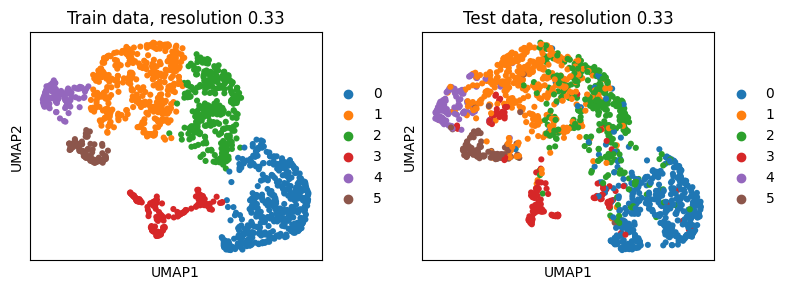

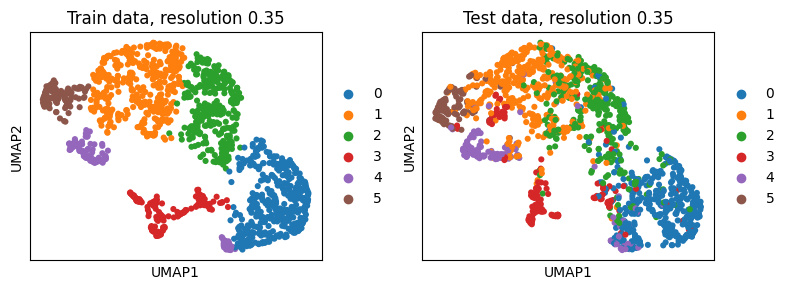

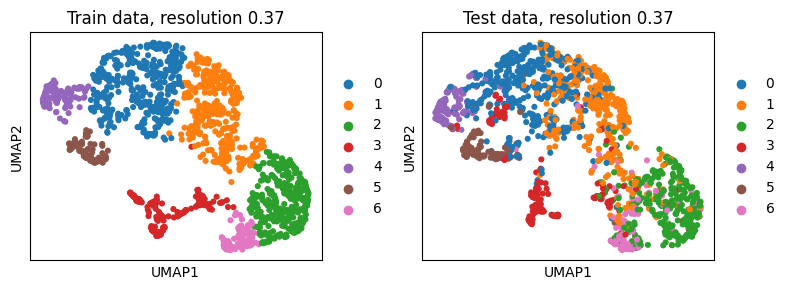

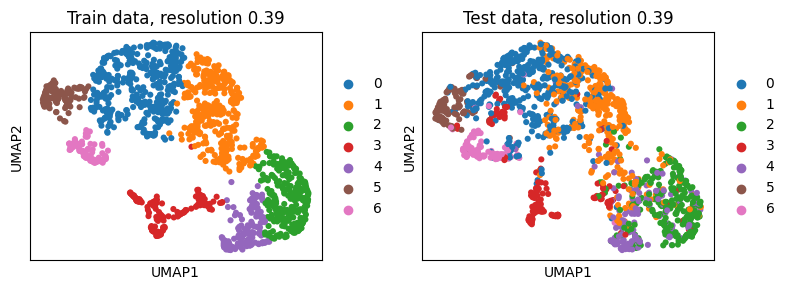

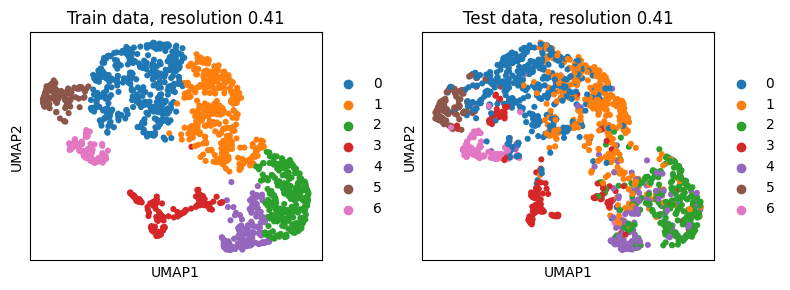

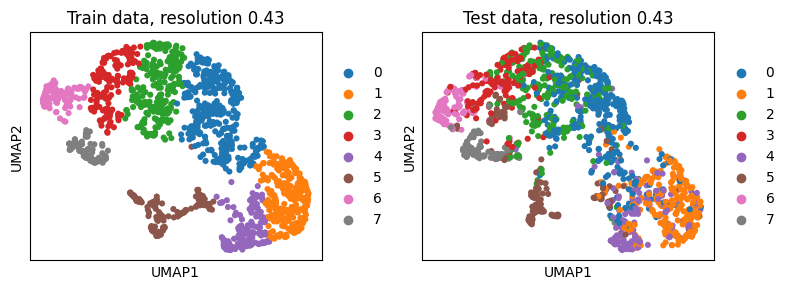

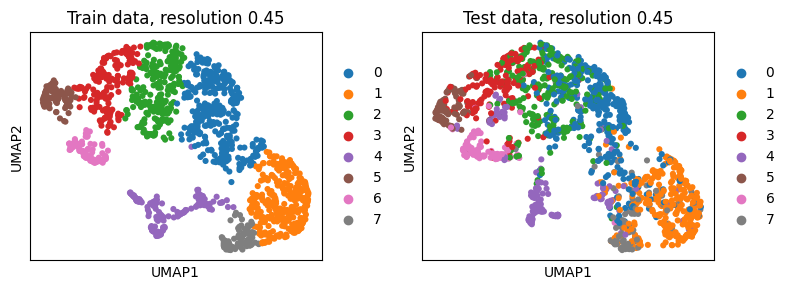

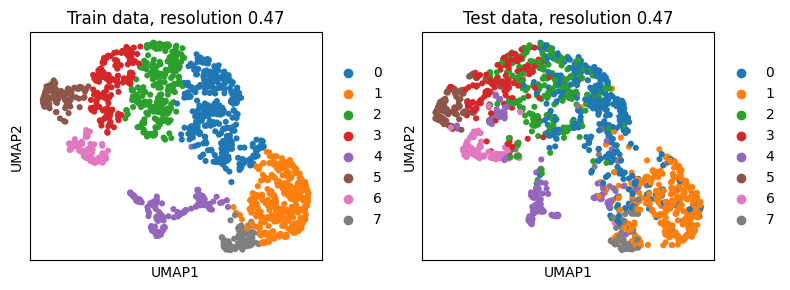

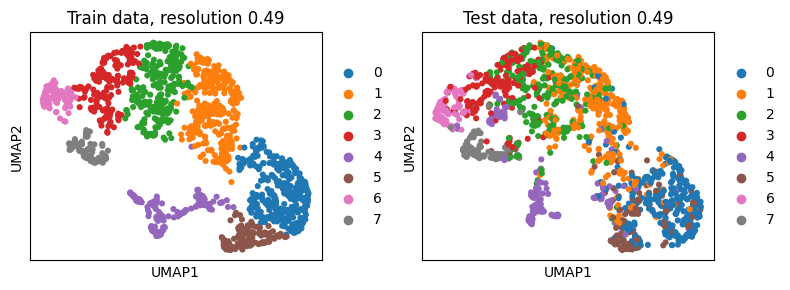

In [87]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(
        data_train,
        color=f"PCA_leiden_res{resolution}",
        ax=ax[0],
        title=f"Train data, resolution {resolution}",
        show=False,
        neighbors_key="PCA",
    )
    sc.pl.embedding(
        data_test,
        basis="X_umap_rot",
        color=f"PCA_leiden_res{resolution}",
        ax=ax[1],
        title=f"Test data, resolution {resolution}",
        show=False,
        neighbors_key="PCA",
    )
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

In [90]:
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(
    data_train,
    data_test,
    resolutions,
    random_seed=1234,
    neighbors_key="PCA",
    res_key="PCA_leiden_res",
)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.456 - Test: 0.421 - Random: 0.249
resolution: 0.07 - clusters: 2 - Train: 0.445 - Test: 0.41 - Random: 0.238
resolution: 0.09 - clusters: 2 - Train: 0.434 - Test: 0.387 - Random: 0.206
resolution: 0.11 - clusters: 3 - Train: 0.431 - Test: 0.367 - Random: 0.131
resolution: 0.13 - clusters: 3 - Train: 0.425 - Test: 0.362 - Random: 0.126
resolution: 0.15 - clusters: 4 - Train: 0.419 - Test: 0.354 - Random: 0.113
resolution: 0.17 - clusters: 4 - Train: 0.413 - Test: 0.35 - Random: 0.105
resolution: 0.19 - clusters: 4 - Train: 0.406 - Test: 0.339 - Random: 0.093
resolution: 0.21 - clusters: 4 - Train: 0.399 - Test: 0.33 - Random: 0.088
resolution: 0.23 - clusters: 5 - Train: 0.397 - Test: 0.303 - Random: 0.061
resolution: 0.25 - clusters: 5 - Train: 0.394 - Test: 0.291 - Random: 0.055
resolution: 0.27 - cl

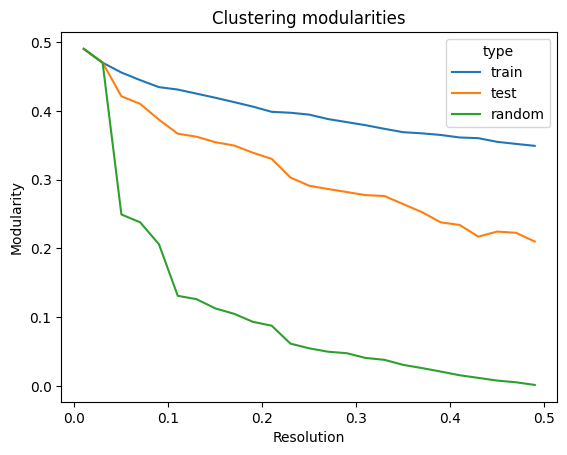

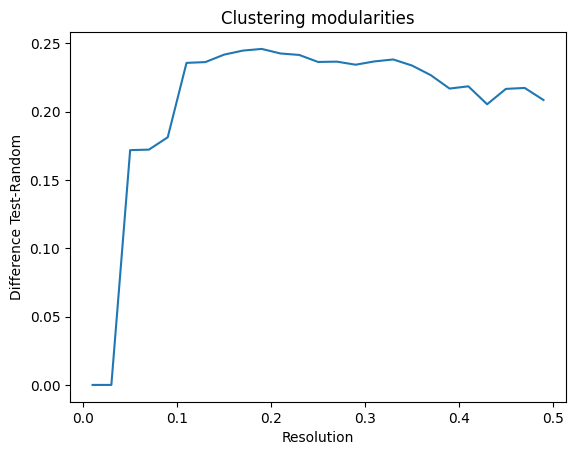

In [91]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [92]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'pca', 'BacSC_params_PCA', 'PCA', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'PCA_distances', 'PCA_connectivities'

In [93]:
res_opt = 0.19
data_gene.uns["BacSC_params_PCA"]["res_opt"] = res_opt

#### Apply clustering to full dataset

In [94]:
sc.tl.leiden(
    data_gene,
    resolution=res_opt,
    key_added="leiden_opt_PCA",
    neighbors_key="PCA",
    random_state=234,
)

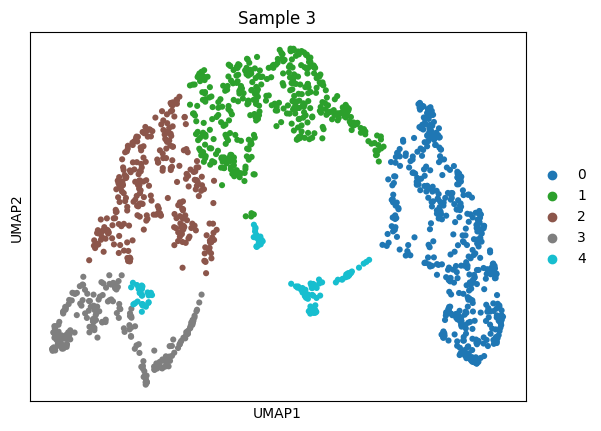

In [95]:
sc.pl.umap(
    data_gene,
    color="leiden_opt_PCA",
    palette="tab10",
    title="Sample 3",
    neighbors_key="PCA",
)
plt.show()

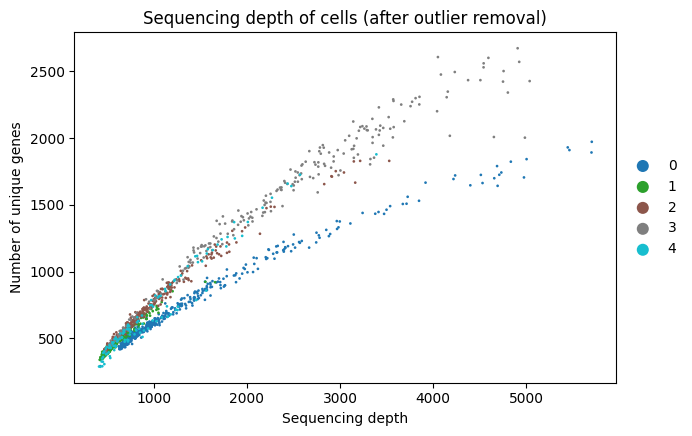

In [96]:
sc.pl.scatter(
    data_gene,
    x="total_counts",
    y="n_genes_by_counts",
    show=False,
    size=15,
    color="leiden_opt_PCA",
)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Checkpoint: save to disk for further analysis

In [97]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")